In [1]:
%matplotlib inline

from torch.distributions.normal import Normal
import torch
from torch import tensor
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from third_party.gmm_torch.gmm import GaussianMixture
from card_1_lib import plot_distribution

Welcome to misinfo sim! 

This is a multi-agent reinforcement learning simulator built to explore how information spreads in environments that mimic social media. 

That might sound like a lot! So I'm going to do a really simple walkthrough, explaining the concepts from the ground up through a quick tutorial on how to make a misinfo sim!

This is targeted at people who have some idea of what reinforcement learning is, but no deep knowledge is required. [Skimming this article](https://towardsdatascience.com/reinforcement-learning-101-e24b50e1d292) would be more than enough. Hang tight!

We are going to walk through creating a simple sim environment, step by step, from scratch. Most of these sim environments end up kinda looking like a game, so I'll just present this as a game, and explain how it's more than that as we go along.

Here's the game: ***THE WOLF FOREST***

A group of explorers want to set up a village in a forest, but they don't want their children to be eaten by wolves. They decide to explore the forest and take note of the locations of any wolf sightings, with the goal of building their home as far from the wolf dens as possible. The explorers can only share information with eachother via notes. 

However, there is also a sly fox with immaculate handwriting that does not want the explorers building a village near its den. The fox wants to trick the villagers by leaving fake notes of wolf sightings near its den. 

The explorers will know:
- The location of any wolves they see
- The location of any wolves from notes they find in the forest
- The number of wolf dens there are

The explorers will not know
- Whether a note is from a fox or a fellow explorer

To start, lets create our forest! We will say that wolf sightings are normally distributed around each wolf den, this is also known as a bell curve or gaussian distribution. Since there are multiple dens, this becomes a distribution called a *mixture of gaussians*, which is luckily pretty easy to model!

Each den will have a mean, which would be the location of the den, and a variance, which indicates how far out wolves tend to go from the den. 

Lets define and plot an example forest below!

I'm going to have 3 dens, at locations (1, 1), (-1, 1), and (1, -1).

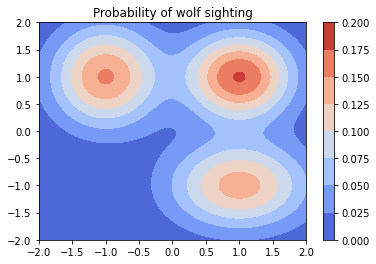

In [2]:
mean = torch.tensor(
    [[
        [1, 1], # Location of den 1
        [-1, 1], # Location of den 2
        [1, -1], # Location of den 3
    ]]
)

variance = torch.tensor(
    [[
        [0.3, 0.3],
        [0.3, 0.4],
        [0.5, 0.3],
    ]]
)

wolf_forest = GaussianMixture(
    n_components=3, # Number of dens
    n_features=2, # Number of dimensions (2 because this is a 2-d map)
    mu_init=mean,
    var_init=variance)
    
plot_distribution(wolf_forest, title="Probability of wolf sighting")

Cool! We can see our forest coming together. The pink and red areas are parts of the forest where you are very likely to run into a wolf. Intuitively we can see that our explorers would be best-off building their village in the bottom left corner of the forest. 

Speaking of explorers, lets build our explorers!

Our explorers are going to want to explore the forest noting any wolf sightings, and learn from the wolves they see. Using ML terms, our agents are going to want to sample from their environment, and train a model on the incoming data.

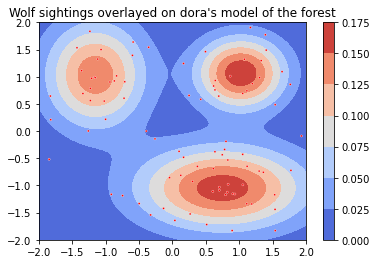

In [3]:
class Explorer:
    def __init__(self):
        self.environment = wolf_forest
    
    def sample(self, num_samples):
        sightings, _ = self.environment.sample(num_samples)
        return sightings
    
    def train(self, data):
        model = GaussianMixture(
                n_components=3,
                n_features=2
        )
        model.fit(data) # Good ol model.fit
        return model

dora = Explorer()
wolf_locations = dora.sample(100) # Dora is seeing 100 wolves, wow!
dora.model = dora.train(wolf_locations)

plot_distribution(dora.model)
sns.scatterplot(x=wolf_locations[:, 0], y=wolf_locations[:, 1], size=0.1, marker=".", color="red", legend=False)
plt.title("Wolf sightings overlayed on dora's model of the forest")
plt.show()

Nice job dora!

We can see after 100 wolf sightings (the red dots) our explorer doesn't have a perfect map of the forest, but it's not too shabby! 

To get an intuition for this process, lets see how this map would look over time at different random wolf sightings. 


(if you're wondering who dora is, go back through the code because you missed a zinger)

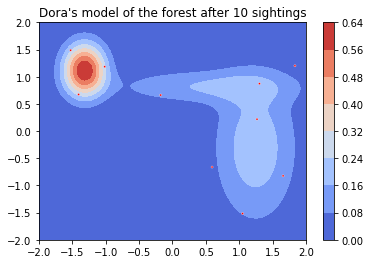

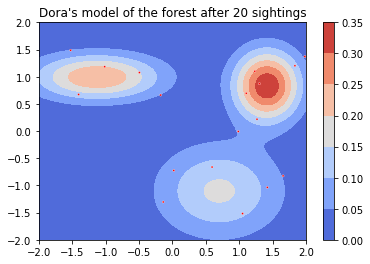

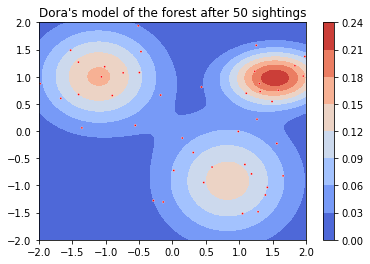

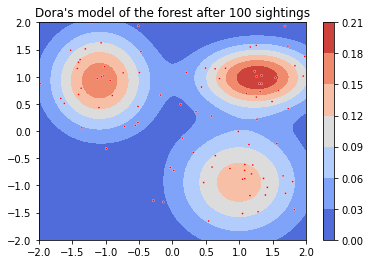

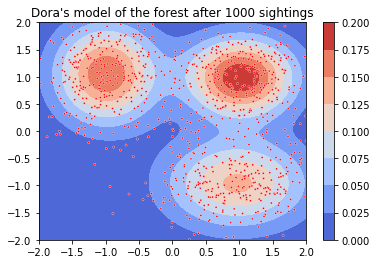

And finally, the real distribution


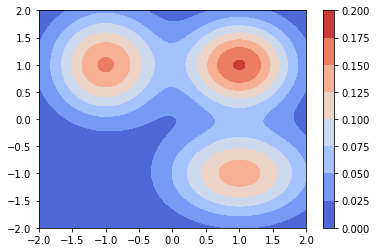

In [4]:
dora = Explorer()
wolf_locations = torch.empty(0, 2)
for n_sightings in [10, 20, 50, 100, 1000]:
    new_sightings = dora.sample(n_sightings - len(wolf_locations)) 
    wolf_locations = torch.cat([wolf_locations, new_sightings])
    dora.model = dora.train(wolf_locations)
    
    plot_distribution(dora.model)
    sns.scatterplot(x=wolf_locations[:, 0], y=wolf_locations[:, 1], size=0.1, marker=".", color="red", legend=False)
    plt.title(f"Dora's model of the forest after {n_sightings} sightings")
    plt.show()

print("And finally, the real distribution")
plot_distribution(wolf_forest)

Awesome! That concludes card #1, introducing the game and the agents. 

In the next two cards I'm going to build on this, introducing more explorers and information sharing, and then finally the dastardly fox! 